In [1]:
import ipyparallel as ipp
def mpi_example():
    comm = MPI.COMM_WORLD
    return f"Hello World from rank {comm.Get_rank()}. total ranks={comm.Get_size()}"

with ipp.Cluster(engines='mpi', n=4) as rc:
    # get a broadcast_view on the cluster which is best
    # suited for MPI style computation
    view = rc.broadcast_view()
    # run the mpi_example function on all engines in parallel
    r = view.apply_sync(mpi_example)
    # Retrieve and print t

from mpi4py import MPI
from petsc4py import PETSc
import matplotlib.pyplot as plt
import numpy as np
import pyvista
import gmsh
from dolfinx import geometry
from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical, locate_dofs_topological
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import VTXWriter, gmshio
from dolfinx.mesh import create_unit_square,create_rectangle,CellType
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,Measure,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym,
                 SpatialCoordinate, conditional, ge, le)

Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/4 [00:00<?, ?engine/s]

Stopping engine(s): 1730199859
Output for ipengine-1730199858-22j4-1730199859-6756:
2024-10-29 12:04:20.360 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-10-29 12:04:20.360 [IPEngine] WARNING | Not using CurveZMQ security
2024-10-29 12:04:20.365 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-10-29 12:04:20.365 [IPEngine] WARNING | Not using CurveZMQ security
2024-10-29 12:04:20.381 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-10-29 12:04:20.381 [IPEngine] WARNING | Not using CurveZMQ security
2024-10-29 12:04:20.450 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-10-29 12:04:20.450 [IPEngine] WARNING | Not using CurveZMQ security
2024-10-29 12:04:21.244 [IPEngine.3] Registering with controller at tcp://127.0.0.1:39723
2024-10-29 12:04:21.244 [IPEngine.1] Registering with controller at tcp://127.0.0.1:39723
2024-10-29 12:04:21.244 [IPEngine.0] Registering with controller at tcp://127.0.0.1:39723
2024-10-29 12:

In [2]:
# Plotting functions
# Get mass flow and pressure
def mfl_press(x_max, mesh, u_n, p):
    # Extract the normal component of velocity (u_x in 2D)
    u_sub = u_n.sub(0)

    # Define measures and spatial coordinates
    dx = Measure("dx", domain=mesh)
    x = SpatialCoordinate(mesh)
    x_pos = int(x_max/2)

    slice_condition = conditional(ge(x[0], x_pos - 5e-1), 1.0, 0.0) * conditional(le(x[0], x_pos + 5e-1), 1.0, 0.0)
    # Calculate mass flow rate at the current slice
    mass_flow = assemble_scalar(form(u_sub * slice_condition * dx))
    # Calculate average pressure at the current slice
    #pressure_avg = assemble_scalar(form(p * slice_condition * dx)) / assemble_scalar(form(slice_condition * dx))
    pressure_avg = 0
    return mass_flow, pressure_avg

def plot_para_velo(ax,mesh, u_n,p_n, t, length, pres, a6, a7):
    if MPI.COMM_WORLD.rank == 0:
        fig, ax = plt.subplots()
        plt.xlabel('y')
        plt.ylabel('u_n')
        plt.title('u_n values at different x-coordinates')
        tol = 0.05  # Avoid hitting the outside of the domain
        y = np.linspace(0+tol, length-tol, int(length*100))
        #x = np.linspace(0+tol, length-tol, int(length*100))
        points = np.zeros((3, int(length*100)))
        points[1] = y
        points[0] = tol
        
        bb_tree = geometry.bb_tree(mesh, mesh.topology.dim)
        cells, cells1, cells2, p_o_p, p_o_p1, p_o_p2 = [], [], [], [], [], []
        # Find cells whose bounding-box collide with the the points
        cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
        # Choose one of the cells that contains the point
        colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i)) > 0:
                p_o_p.append(point)
                cells.append(colliding_cells.links(i)[0])
        
        points[0] = length/2
        # Find cells whose bounding-box collide with the the points
        cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
        # Choose one of the cells that contains the point
        colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i)) > 0:
                p_o_p1.append(point)
                cells1.append(colliding_cells.links(i)[0])
        
        points[0] = length-tol
        # Find cells whose bounding-box collide with the the points
        cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
        # Choose one of the cells that contains the point
        colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i)) > 0:
                p_o_p2.append(point)
                cells2.append(colliding_cells.links(i)[0])
        
        p_o_p = np.array(p_o_p, dtype=np.float64)
        u_values = u_n.eval(p_o_p, cells)
        p_values = p_n.eval(p_o_p, cells)
        
        p_o_p1 = np.array(p_o_p1, dtype=np.float64)
        u_values1 = u_n.eval(p_o_p1, cells1)
        p_values1 = p_n.eval(p_o_p1, cells1)
        
        p_o_p2 = np.array(p_o_p2, dtype=np.float64)
        u_values2 = u_n.eval(p_o_p2, cells2)
        p_values2 = p_n.eval(p_o_p2, cells2)
        plt.title("Velocity over x-Axis")
        plt.plot(p_o_p[:, 1], u_values[:,0], "k", linewidth=2, label="x=0")
        plt.plot(p_o_p1[:, 1], u_values1[:,0], "y", linewidth=2, label=r"x=%s"%(length/2))
        plt.plot(p_o_p2[:, 1], u_values2[:,0], "b", linewidth=2, label=r"x=%s"%(length))
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("Velocity u")
        # If run in parallel as a python file, we save a plot per processor
        plt.savefig(f"para_plot/u_n_p_{int(pres):d}_{int(t*100):d}.pdf") #25_{int(pres):d}_{int(t*100):d}.pdf")

def plot_2dmesh(V, mesh, u_n, c):
    #pyvista.start_xvfb()
    topology, cell_types, geo = vtk_mesh(V)
    values = np.zeros((geo.shape[0], 3), dtype=np.float64)
    values[:, :len(u_n)] = u_n.x.array.real.reshape((geo.shape[0], len(u_n)))
    
    # Create a point cloud of glyphs
    function_grid = pyvista.UnstructuredGrid(topology, cell_types, geo)
    function_grid["u"] = values
    glyphs = function_grid.glyph(orient="u", factor=0.2)
    
    # Create a pyvista-grid for the mesh
    grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))
    
    # Create plotter
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, style="wireframe", color="k")
    plotter.add_mesh(glyphs)
    plotter.view_xy()
    if not pyvista.OFF_SCREEN:
        plotter.show()
        plotter.screenshot(f"canal_{c:d}.png")
    else:
        #f"para_plot/u_n_p_canal_test")#{int(pres):d}
        fig_as_array = plotter.screenshot(f"glyphs_{c:d}.png")

In [3]:
def run_sim(height=1, length=1,pres=8,T=.5,num_steps=500,r=0, file=False, run=1, pyvista_plot=False):
    if run==0:
        mesh = create_rectangle(MPI.COMM_WORLD,[[0,0], [length, height]],[int(length*25),int(height*25)])
    if run == 1:
        mesh = create_unit_square(MPI.COMM_WORLD, 100, 100)
    if run == 2:
        mesh, ft, inlet_marker,outlet_marker, upper_wall_marker, lower_wall_marker, obstacle_marker = create_obst(height, length, MPI.COMM_WORLD, r)
    t = 0
    pres = 8 * length
    dt = T / num_steps

    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)
    
    u = TrialFunction(V)
    v = TestFunction(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)

    fdim = mesh.topology.dim - 1

    def walls(x):
        return np.logical_or(np.isclose(x[1], 0), np.isclose(x[1], height))
    
    wall_dofs = locate_dofs_geometrical(V, walls)
    u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bc_noslip = dirichletbc(u_noslip, wall_dofs, V)
    
    def inflow(x):
        return np.isclose(x[0], 0)
    
    inflow_dofs = locate_dofs_geometrical(Q, inflow)
    bc_inflow = dirichletbc(PETSc.ScalarType(pres), inflow_dofs, Q)
    
    def outflow(x):
        return np.isclose(x[0], length)
    
    outflow_dofs = locate_dofs_geometrical(Q, outflow)
    bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)
    bcu = [bc_noslip]
    bcp = [bc_inflow, bc_outflow]
    
    u_n = Function(V)
    u_n.name = "u_n"
    U = 0.5 * (u_n + u)
    n = FacetNormal(mesh)
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(1))
    rho = Constant(mesh, PETSc.ScalarType(1))
    
    # Define strain-rate tensor
    def epsilon(u):
        return sym(nabla_grad(u))
    
    # Define stress tensor
    def sigma(u, p):
        return 2 * mu * epsilon(u) - p * Identity(len(u))
    
    
    # Define the variational problem for the first step
    p_n = Function(Q)
    p_n.name = "p_n"
    F1 = rho * dot((u - u_n) / k, v) * dx
    F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
    F1 += inner(sigma(U, p_n), epsilon(v)) * dx
    F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
    F1 -= dot(f, v) * dx
    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    
    
    A1 = assemble_matrix(a1, bcs=bcu)
    A1.assemble()
    b1 = create_vector(L1)
    
    # Define variational problem for step 2
    u_ = Function(V)
    a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx)
    L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)
    
    # Define variational problem for step 3
    p_ = Function(Q)
    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)
    
    # Solver for step 1
    solver1 = PETSc.KSP().create(mesh.comm)
    solver1.setOperators(A1)
    solver1.setType(PETSc.KSP.Type.BCGS)
    pc1 = solver1.getPC()
    pc1.setType(PETSc.PC.Type.HYPRE)
    pc1.setHYPREType("boomeramg")
    
    # Solver for step 2
    solver2 = PETSc.KSP().create(mesh.comm)
    solver2.setOperators(A2)
    solver2.setType(PETSc.KSP.Type.BCGS)
    pc2 = solver2.getPC()
    pc2.setType(PETSc.PC.Type.HYPRE)
    pc2.setHYPREType("boomeramg")
    
    # Solver for step 3
    solver3 = PETSc.KSP().create(mesh.comm)
    solver3.setOperators(A3)
    solver3.setType(PETSc.KSP.Type.CG)
    pc3 = solver3.getPC()
    pc3.setType(PETSc.PC.Type.SOR)

    if file:
        from pathlib import Path
        folder = Path("results")
        folder.mkdir(exist_ok=True, parents=True)
        vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
        vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4")
        vtx_u.write(t)
        vtx_p.write(t)
    
    def u_exact(x):
        values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = 4 * x[1] * (1.0 - x[1])
        return values
    
    u_ex = Function(V)
    u_ex.interpolate(u_exact)
    
    L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx)

    fig, ax = plt.subplots()
    plt.xlabel('y')
    plt.ylabel('u_n')
    plt.title('u_n values at different x-coordinates')
    counter = 0
    for i in range(num_steps):
        # Update current time step
        t += dt
    
        # Step 1: Tentative veolcity step
        with b1.localForm() as loc_1:
            loc_1.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        solver1.solve(b1, u_.x.petsc_vec)
        u_.x.scatter_forward()
    
        # Step 2: Pressure corrrection step
        with b2.localForm() as loc_2:
            loc_2.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        solver2.solve(b2, p_.x.petsc_vec)
        p_.x.scatter_forward()
    
        # Step 3: Velocity correction step
        with b3.localForm() as loc_3:
            loc_3.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()
        # Update variable with solution form this time step
        u_n.x.array[:] = u_.x.array[:]
        p_n.x.array[:] = p_.x.array[:]
    
        # print velocity profile
        if (i!=0) and (i % int(num_steps/5) == 0) or (i == num_steps - 1):
            # print(i, u_n.x.array.shape)
            ax = None
            a6, a7 = mfl_press(length, mesh, u_n, p_n)
            plot_para_velo(ax,mesh, u_n, p_n, t, length, pres, a6, a7)
            # print(a6, a7)
            if (pyvista_plot):
                plot_2dmesh(V, mesh, u_n, c=counter)
            counter+=1

        if file:
            # Write solutions to fileV
            vtx_u.write(t)
            vtx_p.write(t)
    
        # Compute error at current time-step
        error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
        error_max = mesh.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
        # Print error only every 20th step and at the last step
        if (i % 20 == 0) or (i == num_steps - 1):
            print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
    # Close xmdf file
    if file:
        vtx_u.close()
        vtx_p.close()
    b1.destroy()
    b2.destroy()
    b3.destroy()
    solver1.destroy()
    solver2.destroy()
    solver3.destroy()
    return u_n, p_n, V, mesh

Time 0.00, L2-error 1.01e+00, Max error 1.60e-02
Time 0.04, L2-error 6.82e-01, Max error 8.95e-06
Time 0.08, L2-error 4.59e-01, Max error 5.90e-06
Time 0.12, L2-error 3.09e-01, Max error 7.34e-06
Time 0.16, L2-error 2.09e-01, Max error 8.45e-06
Time 0.20, L2-error 1.41e-01, Max error 9.28e-06
Time 0.24, L2-error 9.47e-02, Max error 9.88e-06
Time 0.28, L2-error 6.38e-02, Max error 1.03e-05
Time 0.32, L2-error 4.30e-02, Max error 1.06e-05
Time 0.36, L2-error 2.90e-02, Max error 1.08e-05
Time 0.40, L2-error 1.95e-02, Max error 1.10e-05
Time 0.44, L2-error 1.32e-02, Max error 1.11e-05
Time 0.48, L2-error 8.88e-03, Max error 1.12e-05
Time 0.52, L2-error 5.99e-03, Max error 1.12e-05
Time 0.56, L2-error 4.04e-03, Max error 1.13e-05
Time 0.60, L2-error 2.73e-03, Max error 1.13e-05
Time 0.64, L2-error 1.85e-03, Max error 1.13e-05
Time 0.68, L2-error 1.25e-03, Max error 1.13e-05
Time 0.72, L2-error 8.48e-04, Max error 2.36e-05
Time 0.76, L2-error 5.78e-04, Max error 4.06e-05
Time 0.80, L2-error 

(Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 4), blocked element (Basix element (P, triangle, 2, gll_warped, unset, False, float64, []), (2,))), 40),
 Coefficient(FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 4), Basix element (P, triangle, 1, gll_warped, unset, False, float64, [])), 41),
 FunctionSpace(Mesh(blocked element (Basix element (P, triangle, 1, gll_warped, unset, False, float64, []), (2,)), 4), blocked element (Basix element (P, triangle, 2, gll_warped, unset, False, float64, []), (2,))),
 <dolfinx.mesh.Mesh at 0x7f38b25e42f0>)

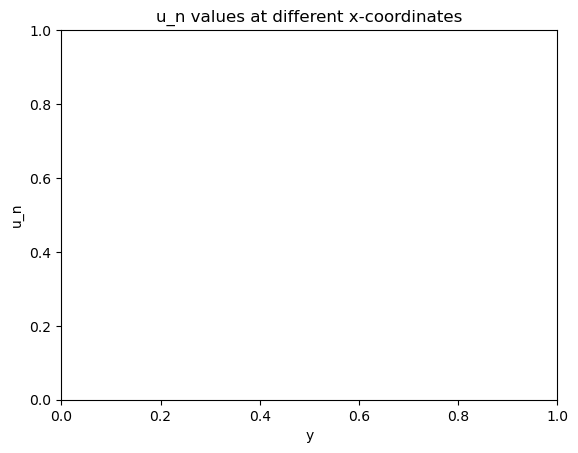

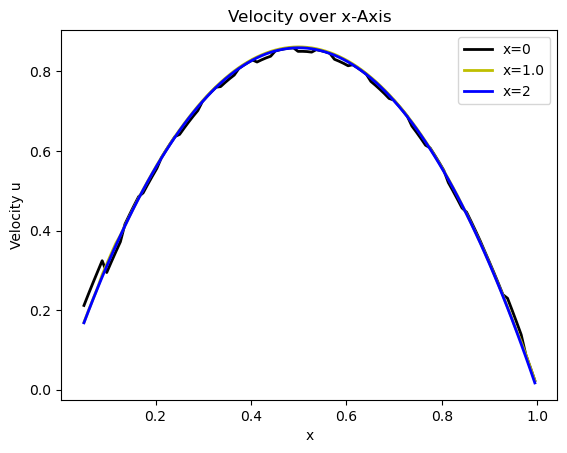

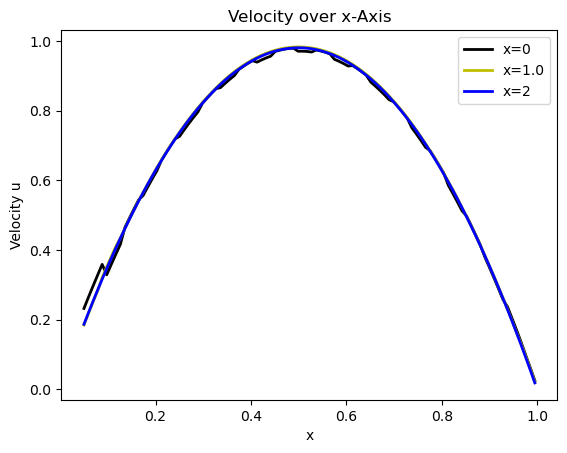

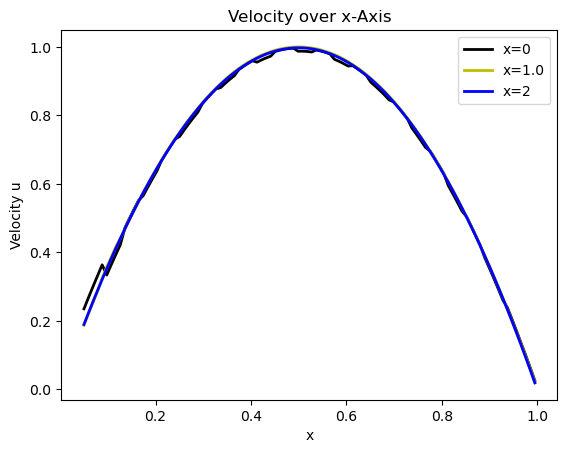

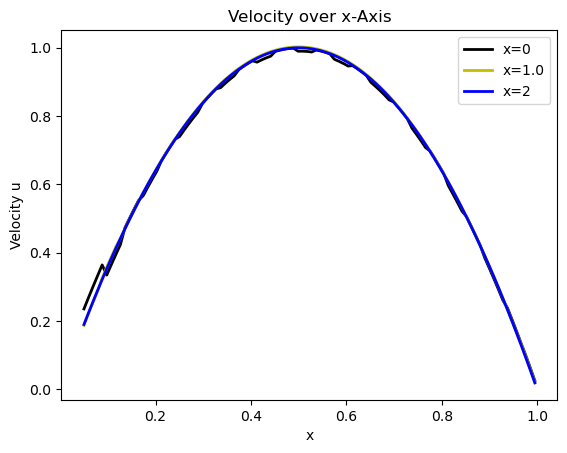

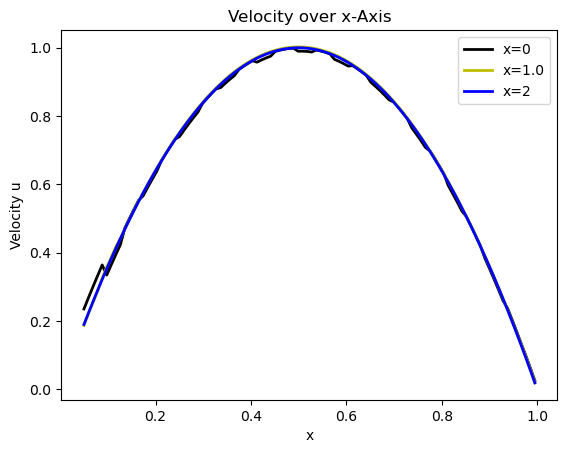

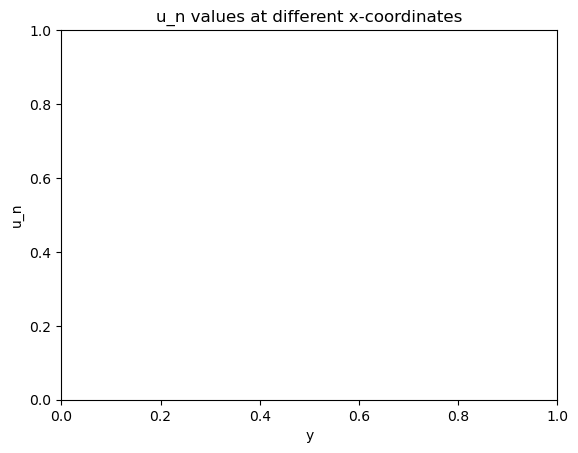

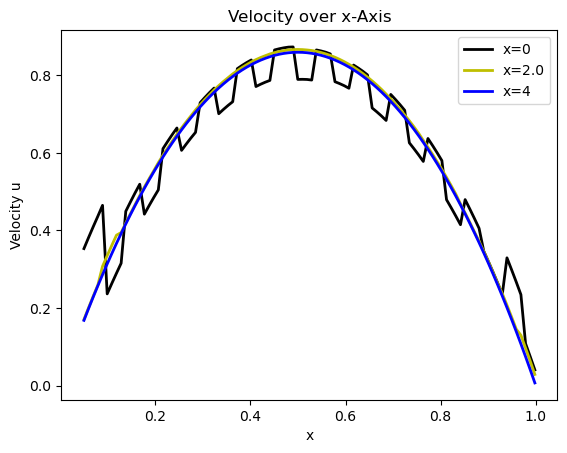

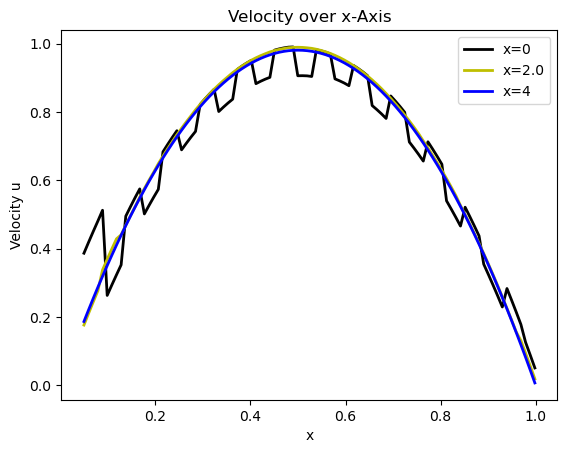

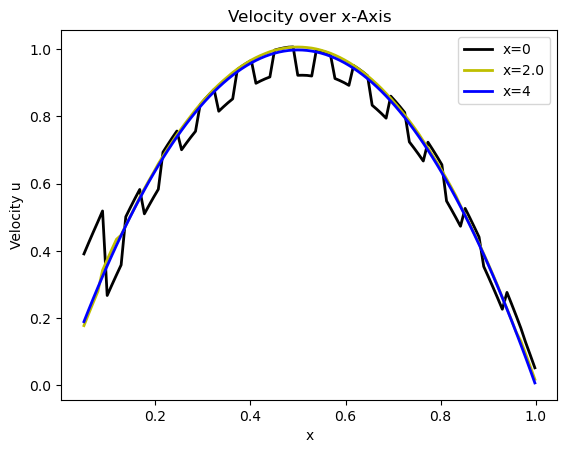

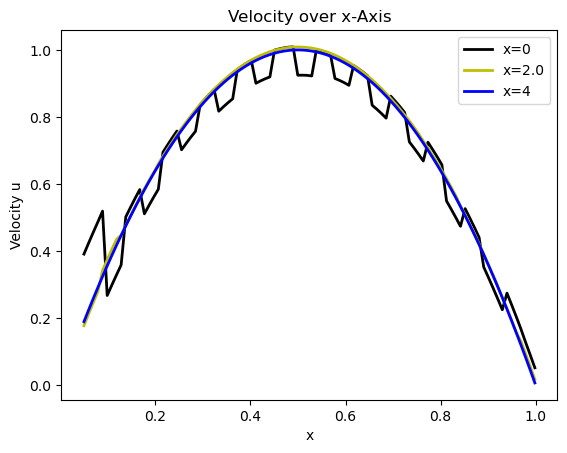

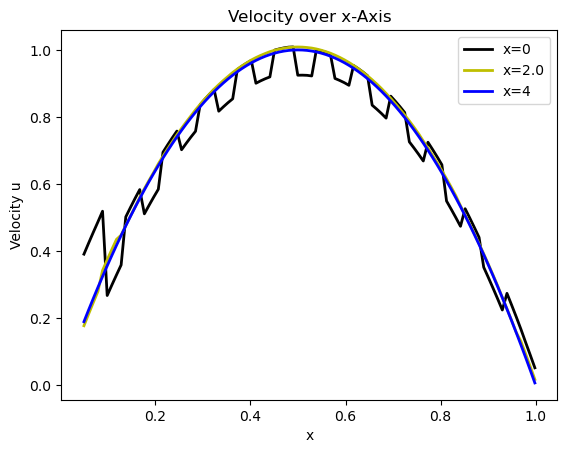

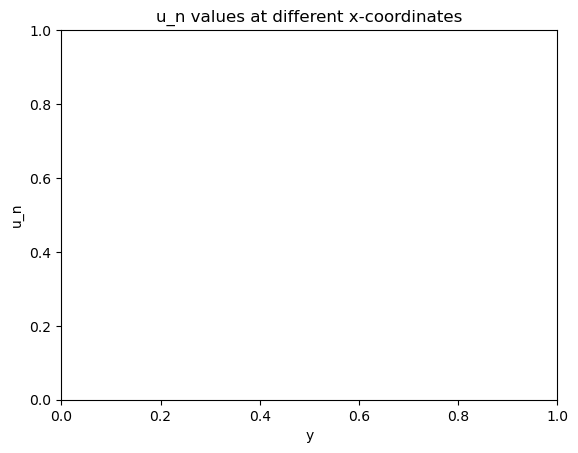

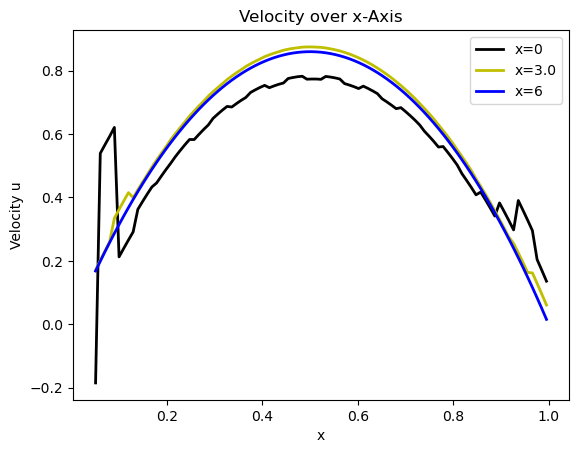

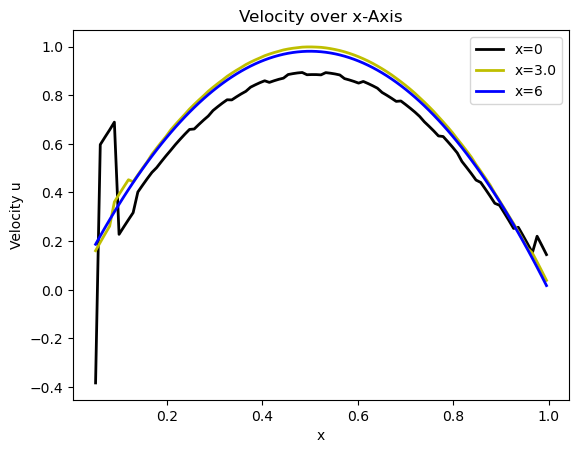

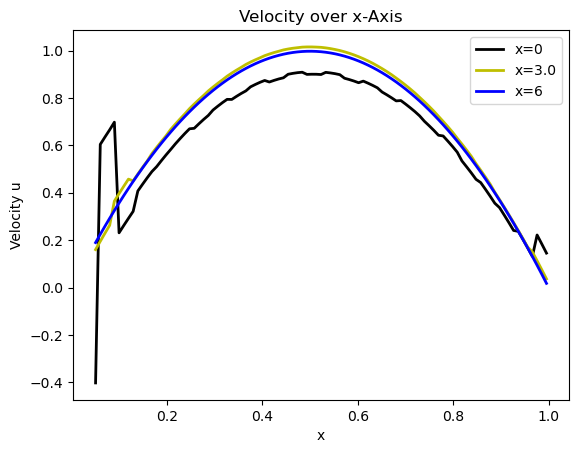

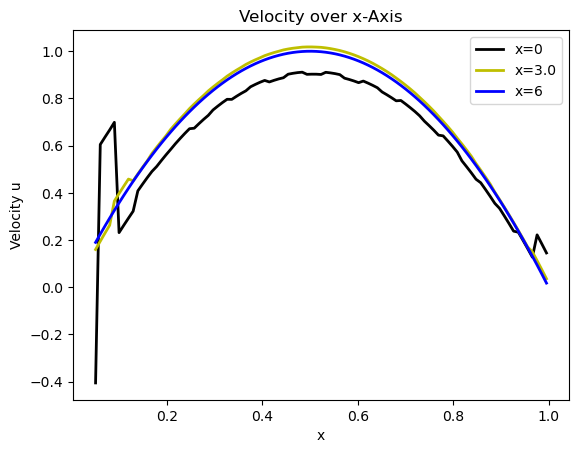

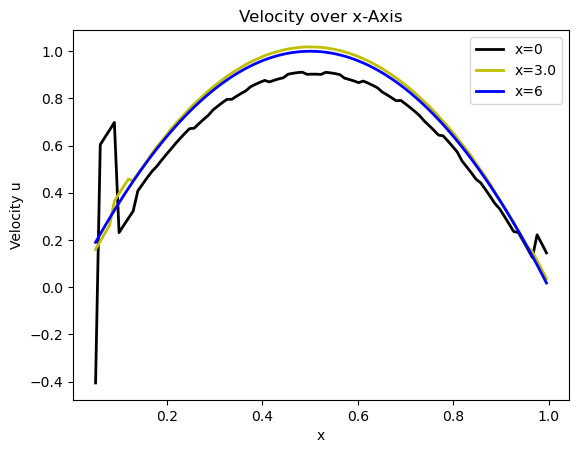

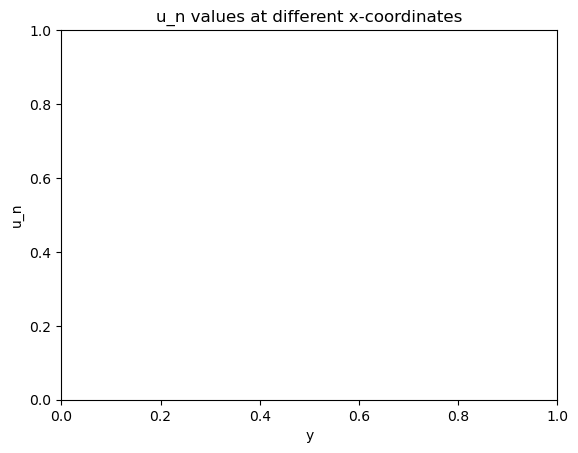

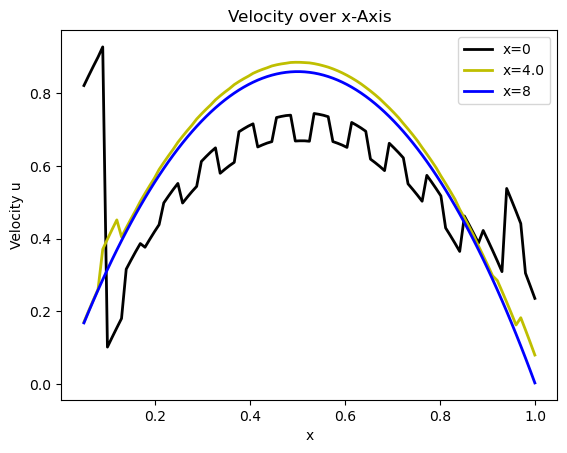

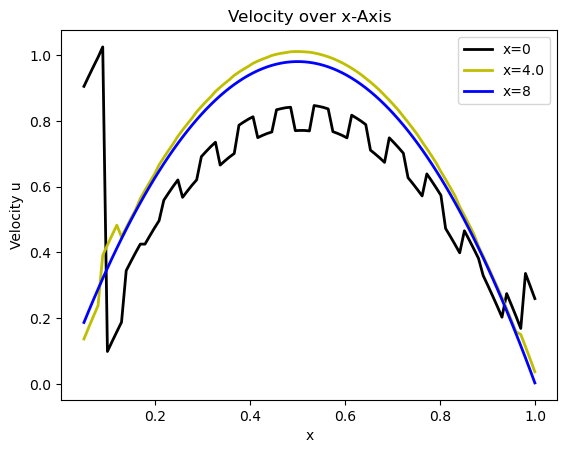

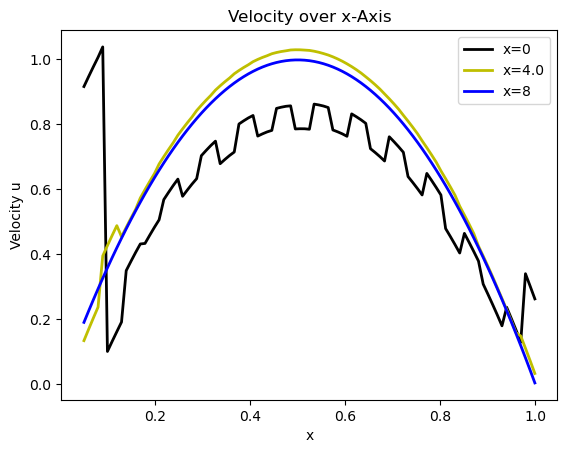

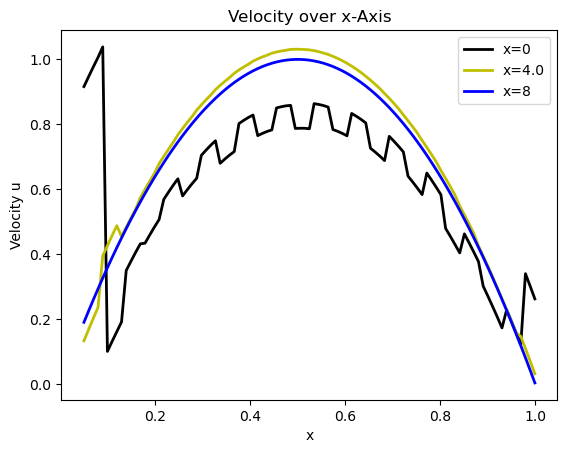

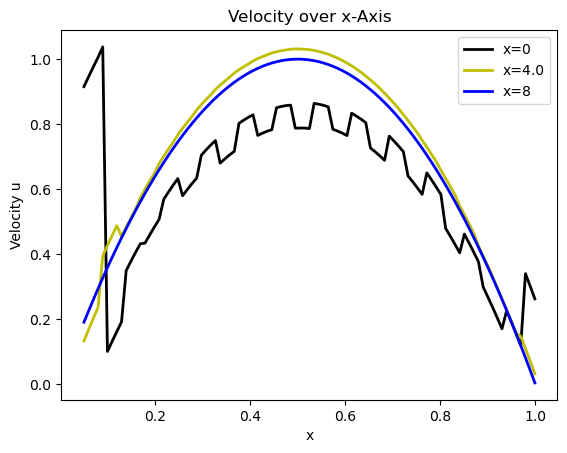

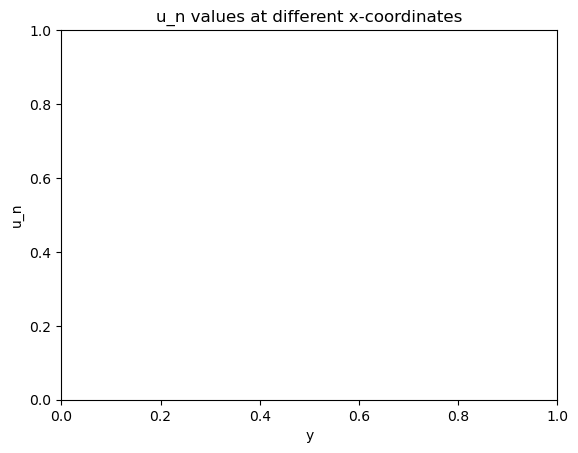

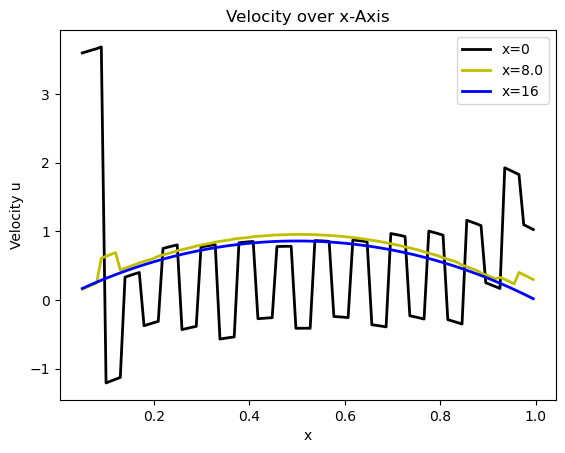

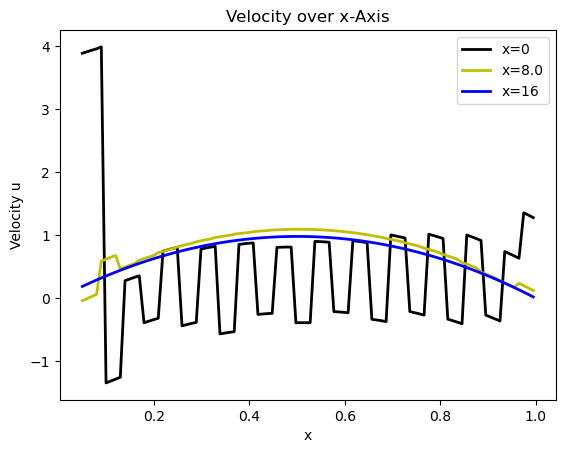

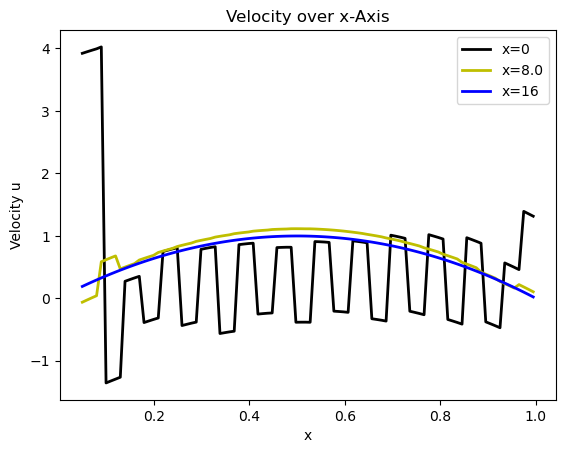

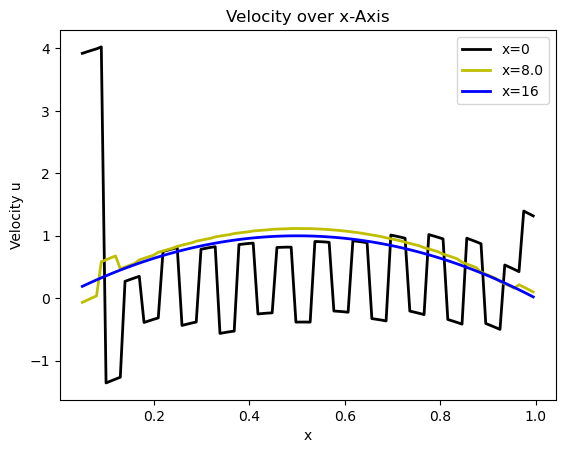

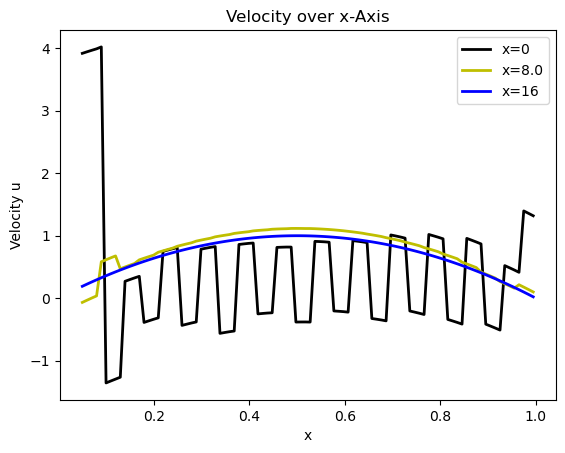

In [4]:
run_sim(height=1,length=2,pres=8,T=1,num_steps=500,file=False,run=0, pyvista_plot=False)
run_sim(height=1,length=4,pres=8,T=1,num_steps=500,file=False,run=0)
run_sim(height=1,length=6,pres=8,T=1,num_steps=500,file=False,run=0)
run_sim(height=1,length=8,pres=8,T=1,num_steps=500,file=False,run=0)
run_sim(height=1,length=16,pres=8,T=1,num_steps=500,file=False,run=0)